In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np                # Management of arrays
import os                         # System utils
import pandas as pd
from pathlib import Path          # path and file utils
from scipy.io import loadmat      # Required to load .mat files
import h5py #For creating new dataset files
import sklearn
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler


!pip install cliffs-delta
from cliffs_delta import cliffs_delta
from scipy.stats import mannwhitneyu

# Models

import sys
sys.path.insert(0,'***')
from basic_model import build_model

!pip install scikeras
from scikeras.wrappers import KerasClassifier, KerasRegressor
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, History
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline

Mounted at /content/drive


# Imports

In [ ]:
# Atlas regions names
data_path='***'

atlas_ROI_names=pd.read_csv(os.path.join('***s', "atlas_ROI_sorted.csv"))
atlas_ROI_names_prefix=copy.deepcopy(atlas_ROI_names)
atlas_ROI_names_prefix.loc[118:169, ('Atlases_sorted')] ='wm_' + atlas_ROI_names.loc[118:169, ('Atlases_sorted')].astype(str)
atlas_ROI_names_prefix.loc[68:117, ('Atlases_sorted')] ='gm_' + atlas_ROI_names.loc[68:117, ('Atlases_sorted')].astype(str)

# HCP
HCP_covars=pd.read_csv(os.path.join(data_path, "HCP_covars_corr.csv"))
HCP_data=pd.read_csv(os.path.join(data_path, "HCP_data_corr.csv"))
n_HCP=HCP_data.shape[0]

# test set
Strat_covars=pd.read_csv(os.path.join(data_path, "test_YA_covar_corr_withglobals.csv"))
Strat_data=pd.read_csv(os.path.join(data_path, "test_YA_data_corr_withglobals.csv"))

n_Strat=Strat_data.shape[0]

In [ ]:
hc_index=Strat_covars[Strat_covars['Diagnosis']==0].index
bd_index=Strat_covars[Strat_covars['Diagnosis']!=0].index

In [ ]:

nonHC_data=Strat_covars[(Strat_covars['Diagnosis']!=0)].reset_index()
BD_data=nonHC_data[nonHC_data['Diagnosis']!=2]
only_bd_index=BD_data.index

In [ ]:
nonHC_data

In [ ]:
only_bd_index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
           dtype='int64', length=187)

In [ ]:
Strat_covars.iloc[only_bd_index,:]

In [ ]:
# Best Model
# [60, 5e-05, 0.0005, [100], 2000, 32]
best_hyperparameters={'model__h_dim': [[100]], 'model__z_dim': [60],
                      'model__learnRate': [0.00005], 'batch_size': [32],
                      'epochs': [2000], 'model__kernel_regul':[0.0005]}

best_hyper=ParameterGrid(best_hyperparameters)[0]
#cb=callbacks=[EarlyStopping(monitor='val_mse', patience=100,restore_best_weights=True), History()]

model=KerasRegressor(model=build_model,random_state=123) #callbacks=[cb]

#I set the model with parameters from param_comb
model=model.set_params(**best_hyper)

history=model.fit(HCP_data, HCP_data, shuffle=True, validation_split=0.1)


Epoch 1/2000
32/32 [==============================] - 1s 6ms/step - loss: 1.7490 - mse: 1.6195 - val_loss: 1.7428 - val_mse: 1.6136
Epoch 2/2000
32/32 [==============================] - 0s 2ms/step - loss: 1.6230 - mse: 1.4940 - val_loss: 1.6396 - val_mse: 1.5109
Epoch 3/2000
32/32 [==============================] - 0s 2ms/step - loss: 1.5262 - mse: 1.3977 - val_loss: 1.5557 - val_mse: 1.4275
Epoch 4/2000
32/32 [==============================] - 0s 3ms/step - loss: 1.4468 - mse: 1.3189 - val_loss: 1.4849 - val_mse: 1.3572
Epoch 5/2000
32/32 [==============================] - 0s 3ms/step - loss: 1.3796 - mse: 1.2522 - val_loss: 1.4242 - val_mse: 1.2969
Epoch 6/2000
32/32 [==============================] - 0s 2ms/step - loss: 1.3205 - mse: 1.1935 - val_loss: 1.3700 - val_mse: 1.2431
Epoch 7/2000
32/32 [==============================] - 0s 2ms/step - loss: 1.2678 - mse: 1.1412 - val_loss: 1.3206 - val_mse: 1.1941
Epoch 8/2000
32/32 [==============================] - 0s 3ms/step - loss: 1.

In [ ]:
#  Save/ Load model
#import load_model
results_path="***/Original_Results/"
model_name='model_original_modmean_lr_betas2.h5'
#model.model_.save(os.path.join(results_path, model_name))
model=tf.keras.models.load_model(os.path.join(results_path, model_name))

Text(0, 0.5, 'Loss')

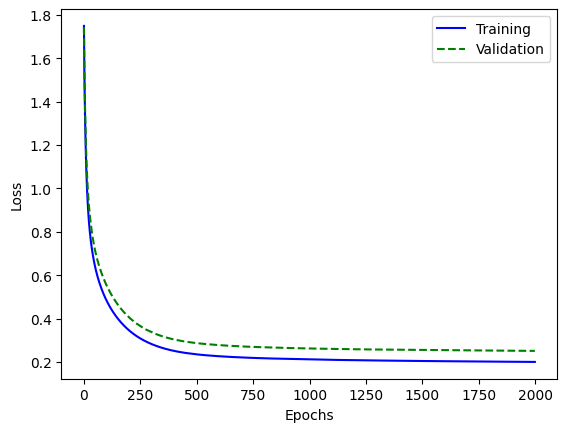

In [ ]:
plt.plot(history.history_["loss"], label="Training Loss", linestyle='-', color='b')
plt.plot(history.history_["val_loss"], label="Validation Loss", linestyle='--', color='g')

plt.legend(['Training', 'Validation'])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [ ]:
# Test the model
Strat_reconstructions = model.predict(Strat_data)

#Calculate Deviation Matrix
strat_dev_map=copy.copy(np.square(Strat_reconstructions-Strat_data))
strat_mean_dev_map=strat_dev_map.mean(axis=1)
#strat_mse = tf.keras.losses.mse(Strat_reconstructions, Strat_data)

HC_strat_dev_map=strat_dev_map.iloc[hc_index,:]
BD_strat_dev_map=strat_dev_map.iloc[bd_index,:]
#HC_strat_mean_dev=strat_mean_dev_map[hc_index]
#BD_strat_mean_dev=strat_mean_dev_map[bd_index]

18/18 [==============================] - 0s 2ms/step


<Axes: >

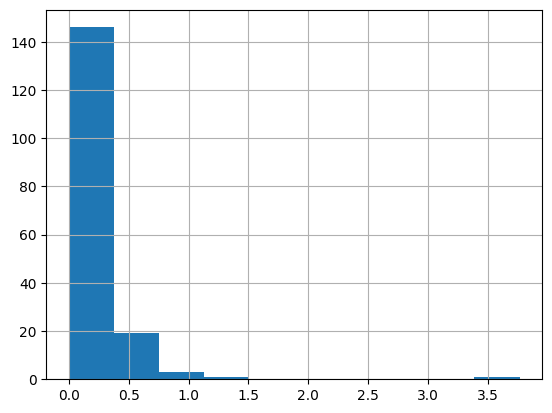

In [ ]:
HC_strat_dev_map.iloc[0,:].hist()

<Axes: >

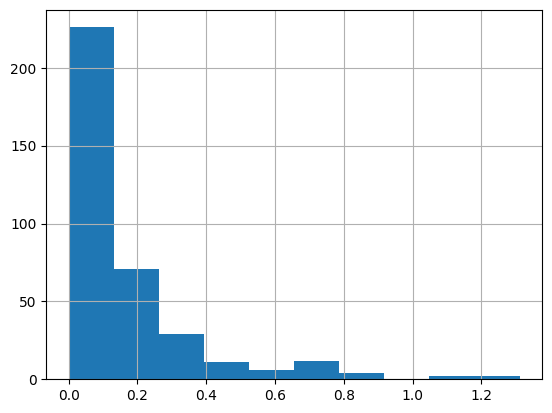

In [ ]:
HC_strat_dev_map.iloc[:,0].hist()

In [ ]:
# Subject deviations

HC_subj_MSE=HC_strat_dev_map.mean(axis=1)
HC_feat_feat=HC_strat_dev_map.mean(axis=0)
HC_RE_mean=HC_subj_MSE.mean()
n_HC=HC_subj_MSE.shape[0]


BD_subj_MSE=BD_strat_dev_map.iloc[only_bd_index,:].mean(axis=1)
BD_feat_MSE=BD_strat_dev_map.iloc[only_bd_index,:].mean(axis=0)
BD_RE_mean=BD_subj_MSE.mean()
n_BD=BD_subj_MSE.shape[0]

# Mean differences

mean_difference=BD_RE_mean-HC_RE_mean

# Feature deviations

HC_feat_MSE=HC_strat_dev_map.mean(axis=0)
BD_feat_MSE=BD_strat_dev_map.mean(axis=0)


In [ ]:
HC_RE_mean

0.20749019246277003

In [ ]:
BD_RE_mean

0.242913773097898

In [ ]:
HC_subj_MSE.median()

0.18664437894236194

In [ ]:
BD_subj_MSE.median()

0.21536144572407118

In [ ]:
mean_difference

0.03542358063512796

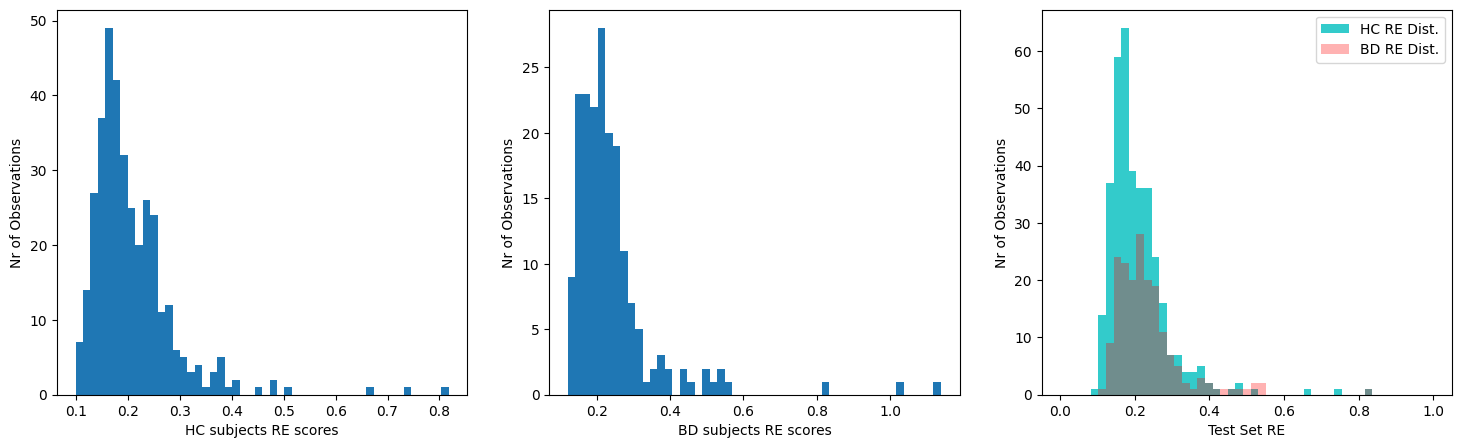

In [ ]:
#Reconstruction error distributions
fig, ax= plt.subplots(1,3, figsize=(18,5))
ax[0].set_xlabel("HC subjects RE scores")
ax[0].set_ylabel("Nr of Observations")
ax[0].hist(HC_subj_MSE, bins=50)

ax[1].set_xlabel("BD subjects RE scores")
ax[1].set_ylabel("Nr of Observations")
ax[1].hist(BD_subj_MSE, bins=50)

bins = np.linspace(0, 1, 50)
#plt.legend(loc='upper right')
ax[2].set_xlabel("Test Set RE")
ax[2].set_ylabel("Nr of Observations")
ax[2].hist(HC_subj_MSE, bins=bins, alpha=0.8, label="HC RE Dist.", color='c')
ax[2].hist(BD_subj_MSE,bins=bins,alpha=0.3, label= "BD RE Dist." ,color='r')
ax[2].legend(labels=["HC RE Dist.", "BD RE Dist."], loc=1, prop={'size': 10})


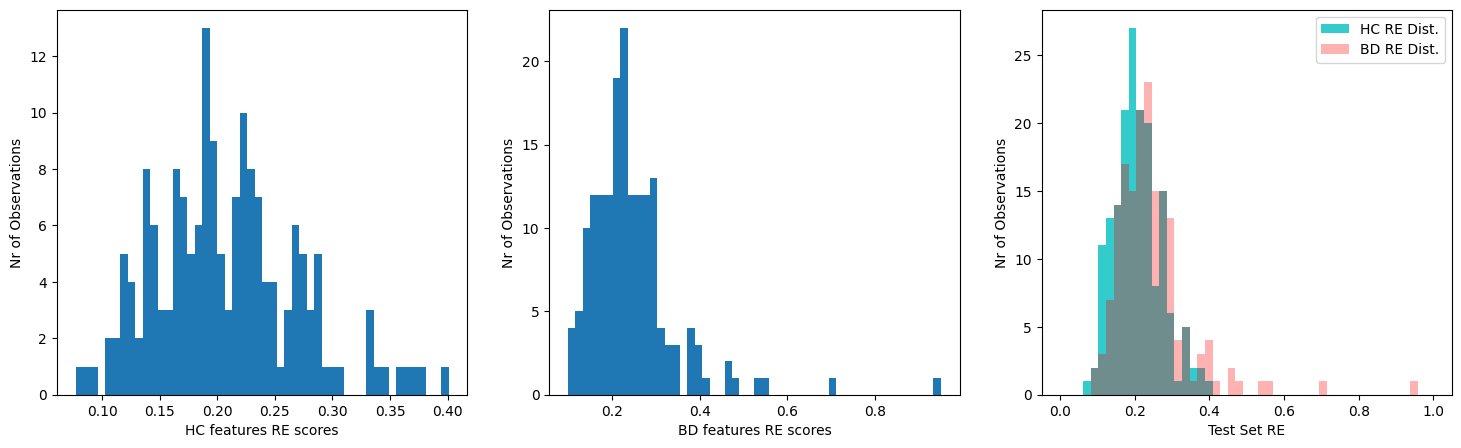

In [ ]:
#Reconstruction error distributions
fig, ax= plt.subplots(1,3, figsize=(18,5))
ax[0].set_xlabel("HC features RE scores")
ax[0].set_ylabel("Nr of Observations")
ax[0].hist(HC_feat_MSE, bins=50)

ax[1].set_xlabel("BD features RE scores")
ax[1].set_ylabel("Nr of Observations")
ax[1].hist(BD_feat_MSE, bins=50)

bins = np.linspace(0, 1, 50)
#plt.legend(loc='upper right')
ax[2].set_xlabel("Test Set RE")
ax[2].set_ylabel("Nr of Observations")
ax[2].hist(HC_feat_MSE, bins=bins, alpha=0.8, label="HC RE Dist.", color='c')
ax[2].hist(BD_feat_MSE,bins=bins,alpha=0.3, label= "BD RE Dist." ,color='r')
ax[2].legend(labels=["HC RE Dist.", "BD RE Dist."], loc=1, prop={'size': 10})


**Save the model results**

In [ ]:
path_save_results=os.path.join(results_path, 'BD_RE_original.csv')

with open(path_save_results, 'w', encoding = 'utf-8-sig') as f:
 BD_strat_dev_map.iloc[only_bd_index,:].to_csv(f)

path_save_results=os.path.join(results_path, 'HC_RE_original.csv')

with open(path_save_results, 'w', encoding = 'utf-8-sig') as f:
 HC_strat_dev_map.to_csv(f)

**analysis bellow : not included in manuscript because results were reported with the bootstrap 95%CI -> check the other script**

In [ ]:
# AUC-ROC
from sklearn import metrics

X_test_dev=np.concatenate((HC_subj_MSE, BD_subj_MSE), axis=0) #avg_dev_subj_bd_test
ones=np.ones((n_BD,1)) #BD_test_scaled
zeros=np.zeros((n_HC,1))
y_test=np.concatenate((zeros,ones),axis=0)

auc = metrics.roc_auc_score(y_test, X_test_dev)

auc

0.6105390315404899

In [ ]:
# Finding abnormal features
n_feat=170

cliffs_d=[]
mwu_pvalues=[]

for f in range(n_feat):
    d, res = cliffs_delta(HC_strat_dev_map.iloc[:,f], BD_strat_dev_map.iloc[:,f])
    cliffs_d.append(d)

    s, pvalue=mannwhitneyu(BD_strat_dev_map.iloc[:,f], HC_strat_dev_map.iloc[:,f], alternative="greater")
    mwu_pvalues.append(pvalue)


significant_diff=list()
i=0
for p in mwu_pvalues:
  if p<=0.05: 
      significant_diff.append(i)
  i+=1

significant_delta=[(i, cliffs_d[i]) for i in significant_diff]

non_negli_deltas=list()
for i, d in significant_delta:
    if np.abs(d)>0.1:
       non_negli_deltas.append(i)


In [ ]:
significant_diff

[0,
 7,
 8,
 12,
 15,
 21,
 41,
 45,
 46,
 63,
 64,
 65,
 72,
 84,
 93,
 96,
 112,
 119,
 128,
 144,
 151,
 158,
 165,
 167,
 168]

In [ ]:
non_negli_deltas

[8, 15, 45, 64, 72, 96, 112, 128, 144, 151, 158, 165]

In [ ]:
# Save original results

#dataframe: HC_mean, BD_mean, AUC
results_dict={'HC_mean_RE': HC_RE_mean, 'BD_mean_RE': BD_RE_mean, 'Group_mean_RE_diff': mean_difference , 'AUC-ROC':auc}

model_original_results=pd.DataFrame.from_dict(results_dict, orient='index', columns=['Value'])

# all feat mean RE
feat_mse_dict={'HC_feat_mse': HC_feat_MSE.values, 'BD_feat_mse': BD_feat_MSE.values}
feat_mse_original=pd.DataFrame(feat_mse_dict, index=atlas_ROI_names_prefix.iloc[:170,0].values)

# all subj mean RE
subj_mse_dict={'HC_feat_mse': HC_subj_MSE.values, 'BD_feat_mse': BD_subj_MSE.values}
subj_mse_original=pd.DataFrame.from_dict(subj_mse_dict, orient='index')

# all abnormal features
abnormal_feat_dict={'regions_names': atlas_ROI_names_prefix.iloc[non_negli_deltas, 0].values, 'cliffs_delta': np.array(cliffs_d)[non_negli_deltas] , 'p_values': np.array(mwu_pvalues)[non_negli_deltas]}
abnormal_feat_original=pd.DataFrame(abnormal_feat_dict, index=non_negli_deltas)
abnormal_feat_original


,regions_names,cliffs_delta,p_values
8,lentorhinal,-0.114490,0.012237
15,rinferiortemporal,-0.153278,0.001298
45,rprecentral,-0.129063,0.005607
64,ltransversetemporal,-0.146997,0.001936
72,gm_lAntCerebLIII,-0.129504,0.005469
96,gm_rAntCerebLI_II,-0.108292,0.016677
112,gm_rCA4,-0.203884,0.000031
128,wm_lSupPostCerebLVIIB,-0.100193,0.024497
144,wm_rStriatum,-0.100386,0.024280
151,wm_rSupPostCerebLVI,-0.107576,0.017269


In [ ]:

path_save_results=os.path.join(results_path, 'model_original_results_***.csv')

with open(path_save_results, 'w', encoding = 'utf-8-sig') as f:
  model_original_results.to_csv(f)

path_save_results=os.path.join(results_path, 'feat_mse_original.csv')
with open(path_save_results, 'w', encoding = 'utf-8-sig') as f:
 feat_mse_original.to_csv(f)

path_save_results=os.path.join(results_path, 'subj_mse_original.csv')
with open(path_save_results, 'w', encoding = 'utf-8-sig') as f:
 feat_mse_original.to_csv(f)

path_save_results=os.path.join(results_path, 'abnormal_feat_original.csv')
with open(path_save_results, 'w', encoding = 'utf-8-sig') as f:
 abnormal_feat_original.to_csv(f)

